In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    'Steps': [3021, 5035, 7049, 9063, 11077, 13091, 15105, 17119],
    'Training Loss': [0.0908, 0.0644, 0.0598, 0.0457, 0.0442, 0.0432, 0.0313, 0.0303],
    'Validation Avg Loss': [3.584, 2.600, 2.658, 2.961, 3.458, 2.754, 2.619, 2.984],
    'Recall': [0.2346, 0.2298, 0.2451, 0.2259, 0.2519, 0.2403, 0.2490, 0.2346]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot 1: Training Loss and Recall
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the training loss on the primary y-axis
sns.lineplot(data=df, x='Steps', y='Training Loss', marker='o', label='Training Loss', ax=ax1)

# Set up the secondary axis for Recall
ax2 = ax1.twinx()
sns.lineplot(data=df, x='Steps', y='Recall', marker='s', label='Recall', ax=ax2, color='green')

# Set labels and title
ax1.set_xlabel('Steps')
ax1.set_ylabel('Training Loss')
ax2.set_ylabel('Recall')
ax1.set_title('Training Loss vs Recall')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Customize the secondary y-axis for Recall
ax2.set_ylim(0, 1)

# Customizing the plot
sns.despine(ax=ax1, right=False)  # Keep the right spine for the secondary axis
ax1.grid(False)  # Disable the grid

# Display the plot
plt.show()

In [1]:
# Plot 2: Validation Loss and Recall
fig, ax3 = plt.subplots(figsize=(10, 6))

# Plot the validation average loss on the primary y-axis
sns.lineplot(data=df, x='Steps', y='Validation Avg Loss', marker='x', label='Validation Avg Loss', ax=ax3)

# Set up the secondary axis for Recall
ax4 = ax3.twinx()
sns.lineplot(data=df, x='Steps', y='Recall', marker='s', label='Recall', ax=ax4, color='green')

# Set labels and title
ax3.set_xlabel('Steps')
ax3.set_ylabel('Validation Loss')
ax4.set_ylabel('Recall')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# Customize the secondary y-axis for Recall
ax4.set_ylim(0.1, 0.4)

# Customizing the plot
sns.despine(ax=ax3, right=False)  # Keep the right spine for the secondary axis
ax3.grid(False)  # Disable the grid

# Display the plot
plt.show()


NameError: name 'plt' is not defined

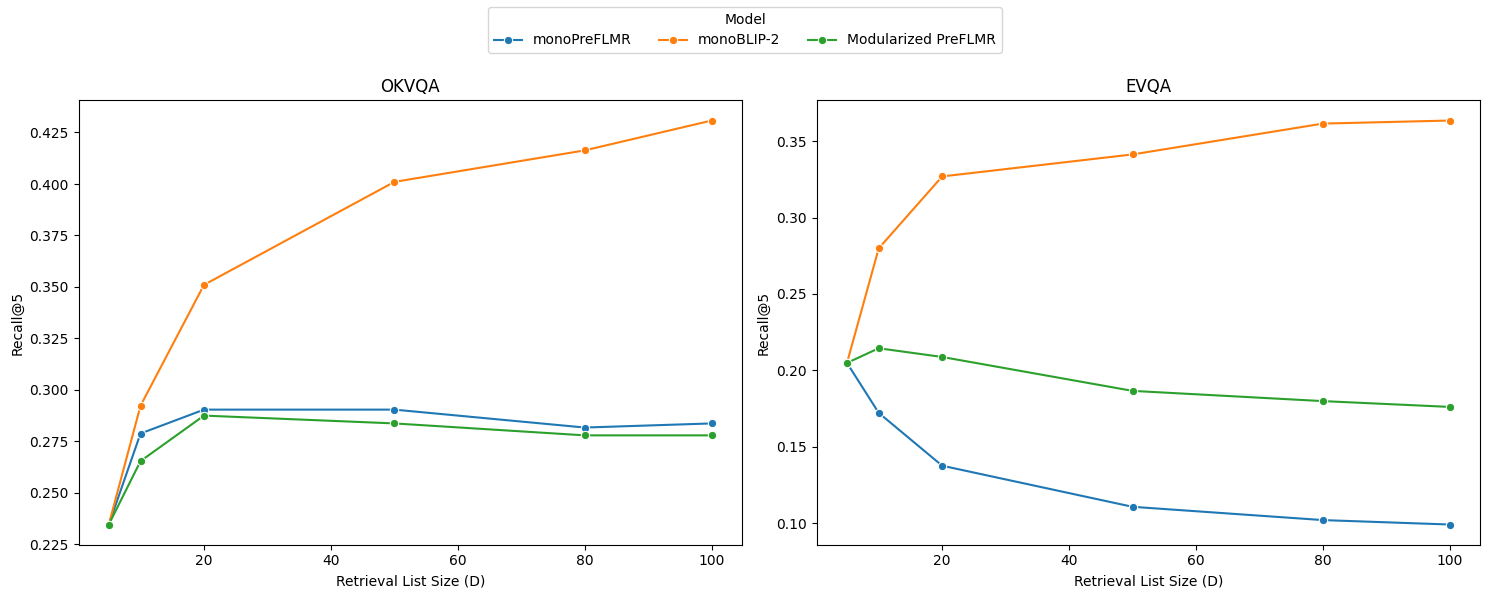

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data preparation
data_okvqa = {
    'D': [5, 10, 20, 50, 80, 100],
    'monoPreFLMR': [0.2346, 0.2788, 0.2904, 0.2904, 0.2817, 0.2837],
    'monoBLIP-2': [0.2346, 0.2923, 0.3510, 0.4010, 0.4163, 0.4308],
    'Modularized PreFLMR': [0.2346, 0.2654, 0.2875, 0.2837, 0.2779, 0.2779]
}

data_evqa = {
    'D': [5, 10, 20, 50, 80, 100],
    'monoPreFLMR': [0.2048, 0.1721, 0.1375, 0.1106, 0.1019, 0.0990],
    'monoBLIP-2': [0.2048, 0.2798, 0.3269, 0.3413, 0.3615, 0.3635],
    'Modularized PreFLMR': [0.2048, 0.2144, 0.2087, 0.1865, 0.1798, 0.1760]
}

# Convert to DataFrame
df_okvqa = pd.DataFrame(data_okvqa)
df_evqa = pd.DataFrame(data_evqa)

# Melt the data for seaborn
df_okvqa_melt = df_okvqa.melt('D', var_name='Model', value_name='Recall@5')
df_evqa_melt = df_evqa.melt('D', var_name='Model', value_name='Recall@5')

# Set up the matplotlib figure and axes
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Plot for OKVQA
sns.lineplot(ax=axes[0], data=df_okvqa_melt, x='D', y='Recall@5', hue='Model', marker='o')
axes[0].set_title('OKVQA')
axes[0].set_xlabel('Retrieval List Size (D)')
axes[0].set_ylabel('Recall@5')
axes[0].legend_.remove()  # Remove the individual legend
axes[0].grid(False)

# Plot for EVQA
sns.lineplot(ax=axes[1], data=df_evqa_melt, x='D', y='Recall@5', hue='Model', marker='o')
axes[1].set_title('EVQA')
axes[1].set_xlabel('Retrieval List Size (D)')
axes[1].legend_.remove()  # Remove the individual legend
axes[1].grid(False)

# Add a single legend for both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, title='Model')

# Adjust the layout
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
